In [1]:
import mlflow
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Sentiment Analysis Baselines")

/home/fabio/Projects/MachineLearning/Sentiment-Analysis-NLP/venv/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:178: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance. For migrating existing data, https://github.com/mlflow/mlflow-export-import can be used.
  return FileStore(store_uri, store_uri)
2026/01/21 15:51:56 INFO mlflow.tracking.fluent: Experiment with name 'Sentiment Analysis Baselines' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///home/fabio/Projects/MachineLearning/Sentiment-Analysis-NLP/notebooks/../mlruns/268443847793296642', creation_time=1769007116470, experiment_id='268443847793296642', last_update_time=1769007116470, lifecycle_stage='active', name='Sentiment Analysis Baselines', tags={}>

2026/01/21 15:52:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 0.892
F1 Score: 0.8919957945754509
              precision    recall  f1-score   support

           0       0.90      0.89      0.89     12500
           1       0.89      0.90      0.89     12500

    accuracy                           0.89     25000
   macro avg       0.89      0.89      0.89     25000
weighted avg       0.89      0.89      0.89     25000



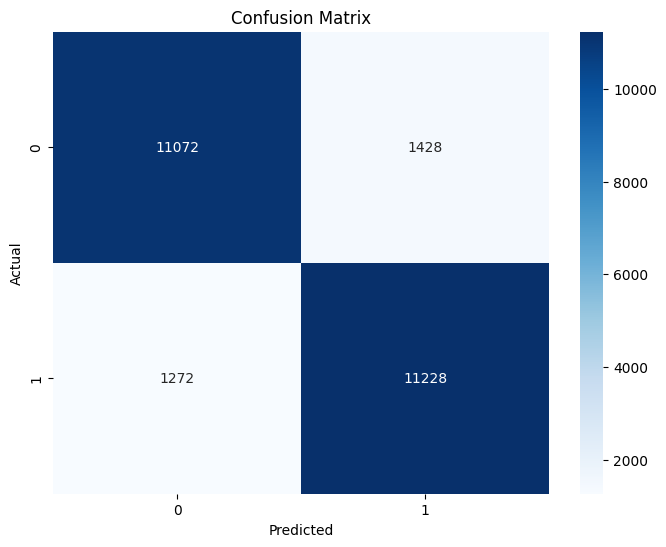

In [4]:
# Load data
train_df = pd.read_csv('../data/processed/train_clean.csv')
test_df = pd.read_csv('../data/processed/test_clean.csv')

x_train = train_df['text_clean']
y_train = train_df['label']

x_test = test_df['text_clean']
y_test = test_df['label']

# TF-IDF Vectorization + Logisitic Regression
with mlflow.start_run(run_name="tfidf-logreg"):
    # Params
    max_features = 10000
    ngram_range = (1, 2)
    C = 1.0

    mlflow.log_param("vectorizer", "tfidf")
    mlflow.log_param("max_features", max_features)
    mlflow.log_param("ngram_range", str(ngram_range))
    mlflow.log_param("model", "logistic_regression")
    mlflow.log_param("C", C)

    # Vectorize
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)

    # Train model
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(x_train_tfidf, y_train)

    # Evaluate
    y_pred = model.predict(x_test_tfidf)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("../figures/confusion_matrix_tfidf_logreg.png")
    mlflow.log_artifact("../figures/confusion_matrix_tfidf_logreg.png")

    # Log model
    mlflow.sklearn.log_model(model, "tfidf-logreg-model")

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(classification_report(y_test, y_pred))

Epoch 1/20, Loss: 0.6296188169733032
Epoch 2/20, Loss: 0.4245503441528286
Epoch 3/20, Loss: 0.37422987243251116
Epoch 4/20, Loss: 0.33767777173529806
Epoch 5/20, Loss: 0.307575282786051
Epoch 6/20, Loss: 0.2750165609981093
Epoch 7/20, Loss: 0.24448452616477256
Epoch 8/20, Loss: 0.20624634187878169
Epoch 9/20, Loss: 0.16567839301593812
Epoch 10/20, Loss: 0.13474611255049687
Epoch 11/20, Loss: 0.10795931873099922
Epoch 12/20, Loss: 0.08292483767632114
Epoch 13/20, Loss: 0.07367918843759552
Epoch 14/20, Loss: 0.05649738791568414
Epoch 15/20, Loss: 0.0552670959008249
Epoch 16/20, Loss: 0.0589485736068069
Epoch 17/20, Loss: 0.04274197574392261
Epoch 18/20, Loss: 0.037814097813158795
Epoch 19/20, Loss: 0.04176014615021839
Epoch 20/20, Loss: 0.03429577705383216


2026/01/21 16:02:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


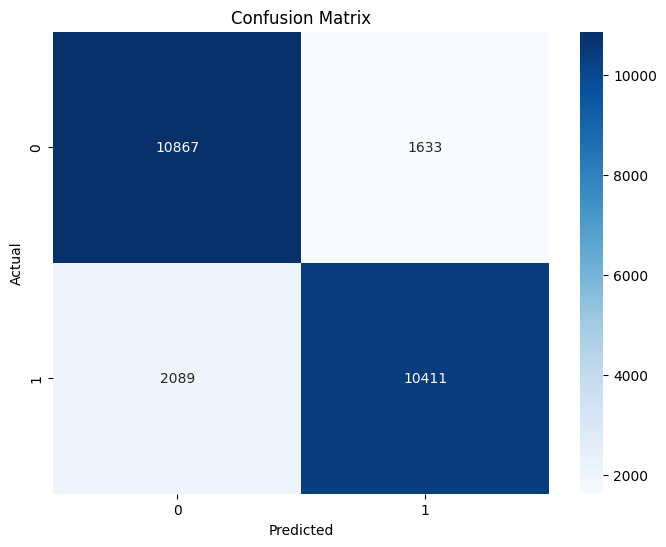

In [6]:
from gensim.models import Word2Vec
import numpy as np

def tokenize(text):
    return text.split()

train_tokens = [tokenize(text) for text in x_train]
test_tokens = [tokenize(text) for text in x_test]

# Train Word2Vec embeddings
w2v_model = Word2Vec(sentences=train_tokens, vector_size=100, window=5,
                    min_count=2, workers=4)

# Convert to sequences
def text_to_sequences(tokens, w2v, max_len=200):
    seq = []
    for token in tokens[:max_len]:
        if token in w2v.wv:
            seq.append(w2v.wv[token])
        else:
            seq.append(np.zeros(100))

    # Pad
    while len(seq) < max_len:
        seq.append(np.zeros(100))

    return np.array(seq)

X_train_seq = np.array([text_to_sequences(t, w2v_model) for t in train_tokens])
X_test_seq = np.array([text_to_sequences(t, w2v_model) for t in test_tokens])

# LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=2,
                  dropout=0.3, bidirectional=True):
        super().__init__()
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers,
                            batch_first=True, dropout=dropout,
                            bidirectional=bidirectional)
        fc_input = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)
        if self.bidirectional:
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]
        out = self.dropout(hidden)
        out = self.fc(out)
        return out
    
# Training loop
with mlflow.start_run(run_name="word2vec-lstm"):
    mlflow.log_param("embedding", "word2vec")
    mlflow.log_param("embedding_dim", 100)
    mlflow.log_param("model", "lstm")
    mlflow.log_param("hidden_dim", 256)
    mlflow.log_param("n_layers", 2)
    mlflow.log_param("dropout", 0.3)
    mlflow.log_param("bidirectional", True)

    # Training
    input_dim = 100
    hidden_dim = 256
    output_dim = 2
    n_layers = 2
    dropout = 0.3

    model = LSTMClassifier(input_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 20
    batch_size = 32
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train_seq, dtype=torch.float32),
                                                   torch.tensor(y_train.values, dtype=torch.long))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    torch.cuda.empty_cache()
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")

    # Evaluation
    model.eval()
    test_dataset = torch.utils.data.TensorDataset(                                     
      torch.tensor(X_test_seq, dtype=torch.float32),                                 
      torch.tensor(y_test.values, dtype=torch.long)
      )                                                                                  
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)       
                                                                                     
    all_preds = []
    with torch.no_grad():                                                              
      for inputs, labels in test_loader:                                             
          inputs = inputs.to(device)                                                 
          outputs = model(inputs)                                                    
          _, preds = torch.max(outputs, 1)                                           
          all_preds.extend(preds.cpu().numpy())                                      
                                                                                     
    y_pred = np.array(all_preds)  

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("learning_rate", 0.001)
    mlflow.log_metric("loss", epoch_loss, step=epoch)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.savefig("../figures/confusion_matrix_w2v_lstm.png")
    mlflow.log_artifact("../figures/confusion_matrix_w2v_lstm.png")

    # Log model
    mlflow.pytorch.log_model(model, "word2vec-lstm-model")

# Results Summary

## Model Comparison

| Model | Accuracy | F1 Score | True Neg | False Pos | False Neg | True Pos |
|-------|----------|----------|----------|-----------|-----------|----------|
| **TF-IDF + LogReg** | **~89.2%** | **~0.89** | 11,072 | 1,428 | 1,272 | 11,228 |
| Word2Vec + LSTM | ~85.1% | ~0.85 | 10,867 | 1,633 | 2,089 | 10,411 |

## Key Findings

### TF-IDF + Logistic Regression (Winner)
- Simple but effective approach for text classification
- Captures important n-grams like "not good", "very bad" through `ngram_range=(1,2)`
- Fast training (seconds) and inference
- No GPU required

### Word2Vec + LSTM
- Improved from ~67% to ~85% after optimization (GPU, bidirectional, more epochs)
- Still underperforms TF-IDF due to Word2Vec trained from scratch on small dataset
- Would benefit from pre-trained embeddings (GloVe, FastText)
- More complex architecture, slower training

## Why TF-IDF Wins?

1. **N-grams capture sentiment patterns**: Bigrams like "not good" are directly encoded
2. **Logistic Regression is powerful**: On well-engineered features, hard to beat without pre-trained models
3. **Word2Vec limitations**: Training on only 25K samples produces suboptimal embeddings
4. **LSTM needs more data**: Deep learning typically requires larger datasets to shine

## Next Steps

The Transformer models (DistilBERT, RoBERTa) should outperform both baselines because:
- Pre-trained on billions of words (massive language understanding)
- Contextual embeddings (same word, different meaning based on context)
- Self-attention captures long-range dependencies better than LSTM